# Know your Car Value 

This is a supervised machine learning problem where it aims to predict the price of the car using its attributes
Predicitons are made by uing the historic data colled from attivo.com

In [29]:
#importing the required libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set_style("white")
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import r2_score
%matplotlib inline


# Data Scraping

In [13]:
#In this note book we first scrap the listings of the ads posted on the site Avito using Beautiful Soup

def get_ads_urls():
    urls_list = []
    # define the basic url to crawl on
    basic_url = "https://www.avito.ma/fr/maroc/voitures-à_vendre?mpr=500000000&o="
    # loop over the paginated urls
    for i in range(1,250):
        # get the page url
        url = basic_url+str(i)
        #print(url)
        # get the request response
        r  = requests.get(url)
        data = r.text
        # transform it to bs object
        soup = BeautifulSoup(data, "lxml")
        # loop over page links
        for div in soup.findAll('div', {'class': 'item-img'}):
            a = div.findAll('a')[0]
            urls_list.append(a.get('href'))


    df = pd.DataFrame(data={"url": urls_list})
    df.to_csv("./carsdata/ads_urls.csv", sep=',',index=False)
get_ads_urls()

In [4]:
def scrap_ad_data(ad_url):
    r = requests.get(ad_url)
    data = r.text
    soup = BeautifulSoup(data, "html.parser")
    target_component = soup.findAll("h2",  {"class": ["font-normal", "fs12", "no-margin", "ln22"]})
    # create a list that will hold our component data
    results = []
    for i in target_component:
        results.append(''.join(i.findAll(text=True)).replace('\n',''))
    return results

In [14]:
def write_data_to_csv(data):
    with open("./carsdata/output.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [8]:
urls_data = pd.read_csv("./ads_urls.csv")
# create  a list that will hold the final data
final_result = []
i = 1
# loop over the dataframe
for index, row in urls_data.iterrows():
    final_result.append(scrap_ad_data(row['url']))
    # to count how many page we have processed since qe have 35 links per page
    #i += 1
    #if i%100 == 0:
    #    print("page ",i, "done")
print('Scrapping data finished')
# now that we have all the data we can write it in a csv file
write_data_to_csv(final_result)

Scrapping data finished


In [11]:
colnames=['price', 'year_model', 'mileage', 'fuel_type', 'mark', 'model', 'fiscal_power', 'sector', 'type', 'city'] 
# read the csv file as a dataframe
df = pd.read_csv("./output.csv", sep=",", names=colnames, header=None)
# let's get some simple vision on our dataset
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,sector,type,city
0,56 000 DH,Année-Modèle:1997,Kilométrage:200 000 - 249 999,Type de carburant:Diesel,Marque:Volkswagen,Modèle:GOLF 3,Puissance fiscale:8 CV,-,"Type:Voitures, Offre",Tan-Tan
1,75 000 DH,Année-Modèle:2008,Kilométrage:15 000 - 19 999,Type de carburant:Diesel,Marque:Peugeot,Modèle:407,Puissance fiscale:8 CV,Secteur:autre_secteur,"Type:Voitures, Offre",Kénitra
2,85 000 DH,Année-Modèle:2015,Kilométrage:55 000 - 59 999,Type de carburant:Diesel,Marque:Ford,Modèle:Focus,Puissance fiscale:8 CV,Secteur:centre_ville,"Type:Voitures, Offre",Casablanca
3,118 000 DH,Année-Modèle:2014,Kilométrage:10 000 - 14 999,Type de carburant:Diesel,Marque:Dacia,Modèle:Lodgy,Puissance fiscale:6 CV,-,"Type:Voitures, Offre",Casablanca
4,85 000 DH,Année-Modèle:2015,Kilométrage:15 000 - 19 999,Type de carburant:Diesel,Marque:Dacia,Modèle:LOGAN MCV,Puissance fiscale:-,Secteur:toute_la_ville,"Type:Voitures, Offre",Barkine


# Data Cleaning

In [12]:
df = df[df.price.str.contains("DH") == True]
# remove the 'DH' caracters from the price
df.price = df.price.map(lambda x: x.rstrip('DH'))
# remove the space on it
df.price = df.price.str.replace(" ","")
# change it to integer value
df.price = pd.to_numeric(df.price, errors = 'coerce', downcast= 'integer')

In [13]:
df.shape

(8709, 10)

In [ ]:
Year Model¶


In [14]:
# remove thos rows doesn't contain the year_model value
df = df[df.year_model.str.contains("Année-Modèle") == True]
# remove the 'Année-Modèle:' from the year_model
df.year_model = df.year_model.map(lambda x: x.lstrip('Année-Modèle:').rstrip('ou plus ancien'))
# df.year_model = df.year_model.map(lambda x: x.lstrip('Plus de '))
# remove those lines having the year_model not set
df = df[df.year_model != ' -']
df = df[df.year_model != '']
# change it to integer value
df.year_model = pd.to_numeric(df.year_model, errors = 'coerce', downcast = 'integer')


In [15]:
df = df[df.mileage.str.contains("Kilométrage") == True]
# remove the 'Kilométrage:' string from the mileage feature 
df.mileage = df.mileage.map(lambda x: x.lstrip('Kilométrage:'))
df.mileage = df.mileage.map(lambda x: x.lstrip('Plus de '))
# remove those lines having the mileage values null or '-'
df = df[df.mileage != '-']
# we have only one value type that is equal to 500 000, all the other ones contain two values
if any(df.mileage != '500 000'):
    # create two columns minim and maxim to calculate the mileage mean
    df['minim'], df['maxim'] = df.mileage.str.split('-', 1).str
    # remove spaces from the maxim & minim values 
    df['maxim'] = df.maxim.str.replace(" ","")
    df['minim'] = df.minim.str.replace(" ","")
    df['maxim'] = df['maxim'].replace(np.nan, 500000)
    # calculate the mean of mileage 
    df.mileage = df.apply(lambda row: (int(row.minim) + int(row.maxim)) / 2, axis=1)
    # now that the mileage is calculated so we do not need the minim and maxim values anymore
    df = df.drop(columns=['minim', 'maxim'])

In [16]:
df.fuel_type = df.fuel_type.map(lambda x: x.lstrip('Type de carburant:'))

In [17]:
df['mark'] = df['mark'].map(lambda x: x.replace('Marque:', ''))
df = df[df.mark != '-']
# remove the 'Modèle:' string from model feature 
df['model'] = df['model'].map(lambda x: x.replace('Modèle:', ''))


In [15]:
df.fiscal_power.value_counts()

Puissance fiscale:-                3161
Puissance fiscale:6 CV             1887
Puissance fiscale:8 CV             1331
Puissance fiscale:7 CV             1009
Puissance fiscale:9 CV              355
Puissance fiscale:5 CV              207
Puissance fiscale:11 CV             199
Puissance fiscale:10 CV             183
Puissance fiscale:12 CV             143
Puissance fiscale:4 CV               41
Puissance fiscale:13 CV              23
Puissance fiscale:17 CV              18
Puissance fiscale:14 CV              14
Puissance fiscale:15 CV               8
Puissance fiscale:18 CV               8
Puissance fiscale:20 CV               6
Puissance fiscale:16 CV               6
Puissance fiscale:Plus de 48 CV       4
Puissance fiscale:21 CV               4
Puissance fiscale: -                  3
Puissance fiscale:-                   3
Puissance fiscale:26 CV               2
Puissance fiscale:31 CV               2
Puissance fiscale:19 CV               2
Puissance fiscale:32 CV               2


In [18]:
# remove the 'Puissance fiscale:' from the fiscal_power feature
df.fiscal_power = df.fiscal_power.map(lambda x: x.lstrip('Puissance fiscale:Plus de').rstrip(' CV'))
# replace the - with NaN values and convert them to integer values
df.fiscal_power = df.fiscal_power.str.replace("-","0")
# convert all fiscal_power values to numerical ones 
df.fiscal_power = pd.to_numeric(df.fiscal_power, errors = 'coerce', downcast= 'integer')
# now we need to fill those 0 values with the mean of all fiscal_power columns
df.fiscal_power = df.fiscal_power.map( lambda x : df.fiscal_power.mean() if x == 0 else x )


In [19]:
# remove those lines having the fuel_type not set
df = df[df.fuel_type != '-']

In [20]:
df = df.drop(columns=['sector', 'type'])

# Exploratory Data Analysis

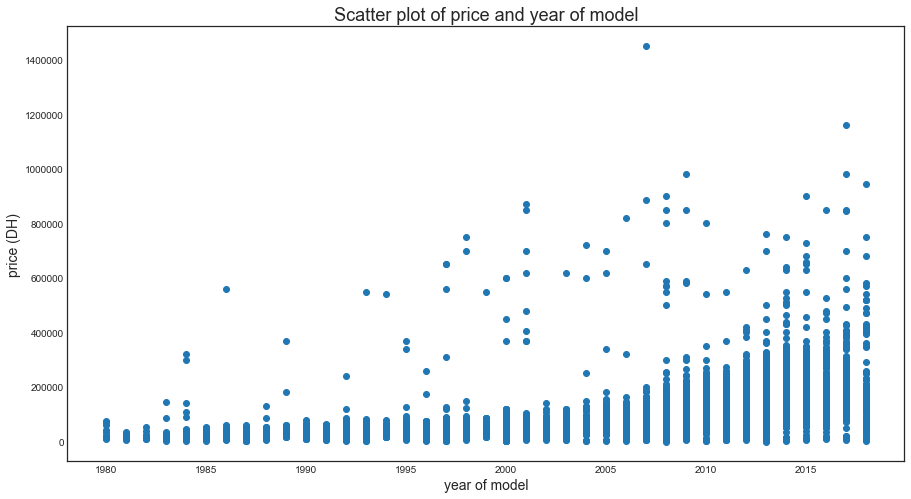

In [21]:

##price distribution by year_model
plt.figure(figsize=(15, 8))
# plot two values price per year_model
plt.scatter(df.year_model,df.price)
plt.ylabel("price (DH)", fontsize=14)
plt.xlabel("year of model", fontsize=14)
plt.title("Scatter plot of price and year of model",fontsize=18)
plt.show()

Price distribution by mark


In [19]:
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,city
0,56000,1997,224999.5,Diesel,Volkswagen,GOLF 3,8.000000,Tan-Tan
1,75000,2008,17499.5,Diesel,Peugeot,407,8.000000,Kénitra
2,85000,2015,57499.5,Diesel,Ford,Focus,8.000000,Casablanca
3,118000,2014,12499.5,Diesel,Dacia,Lodgy,6.000000,Casablanca
4,85000,2015,17499.5,Diesel,Dacia,LOGAN MCV,4.771468,Barkine


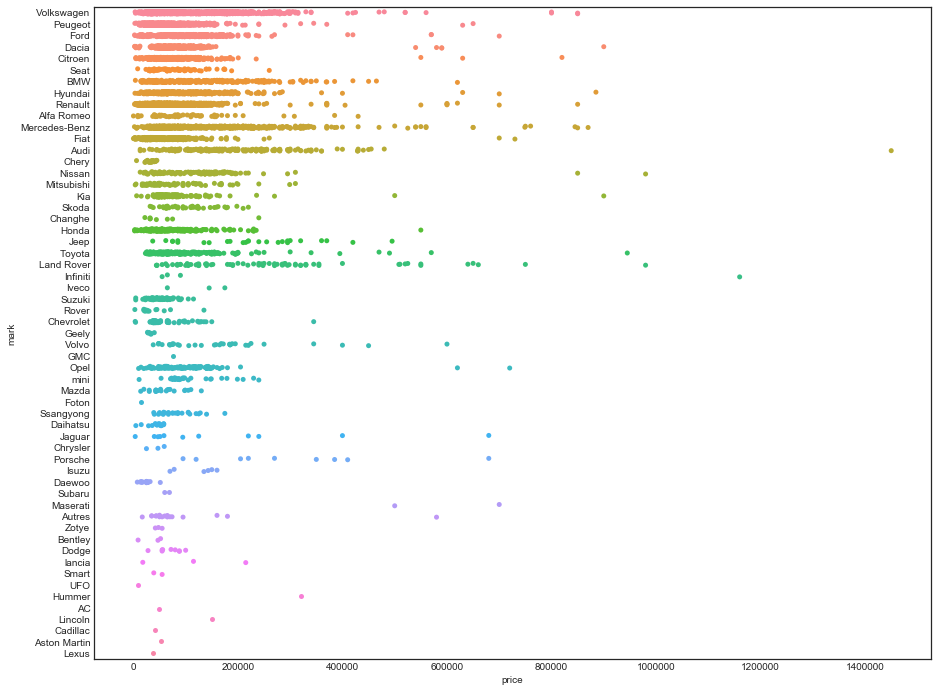

In [23]:
f, ax = plt.subplots(figsize=(15, 12))
sns.stripplot(data = df, x='price', y='mark', jitter=.1)
plt.show()

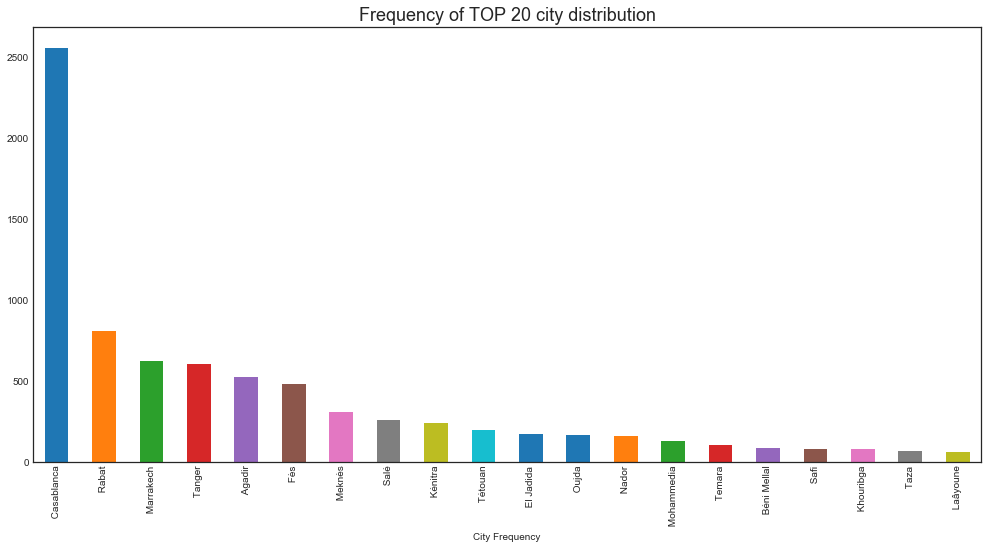

In [15]:
#city distribution
plt.figure(figsize=(17,8))
df.city.value_counts().nlargest(20).plot(kind='bar')
plt.xlabel('City Frequency')
plt.title("Frequency of TOP 20 city distribution",fontsize=18)
plt.show()

# Correlation plot

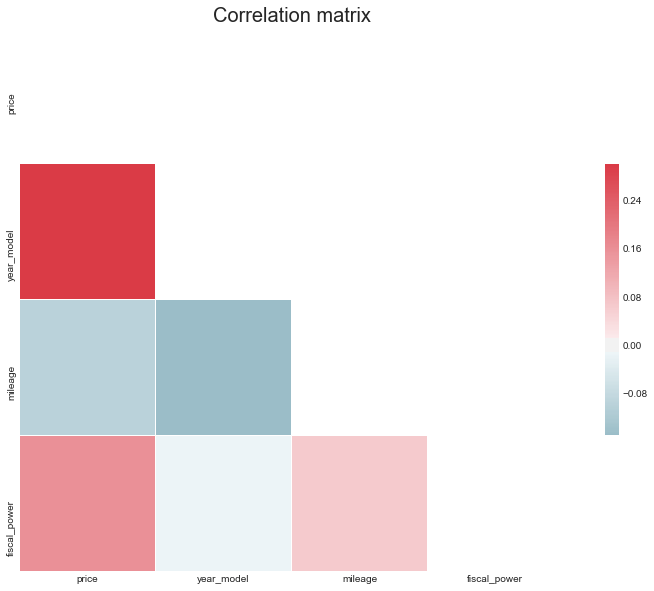

In [24]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))
# Compute the correlation matrix
corr = df.corr()
#print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix', 
          fontsize = 20)
plt.show()

as we can see from the plot the price of the car and year model are highly correlated

In [25]:
#df = df.drop(columns=['sector', 'type'])
data = df[df.price < 400000]
X = data[['year_model', 'mileage', 'fiscal_power', 'fuel_type', 'mark']]
Y = data.price
X = pd.get_dummies(data=X)

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 42)

# k- nearest neighbor

/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


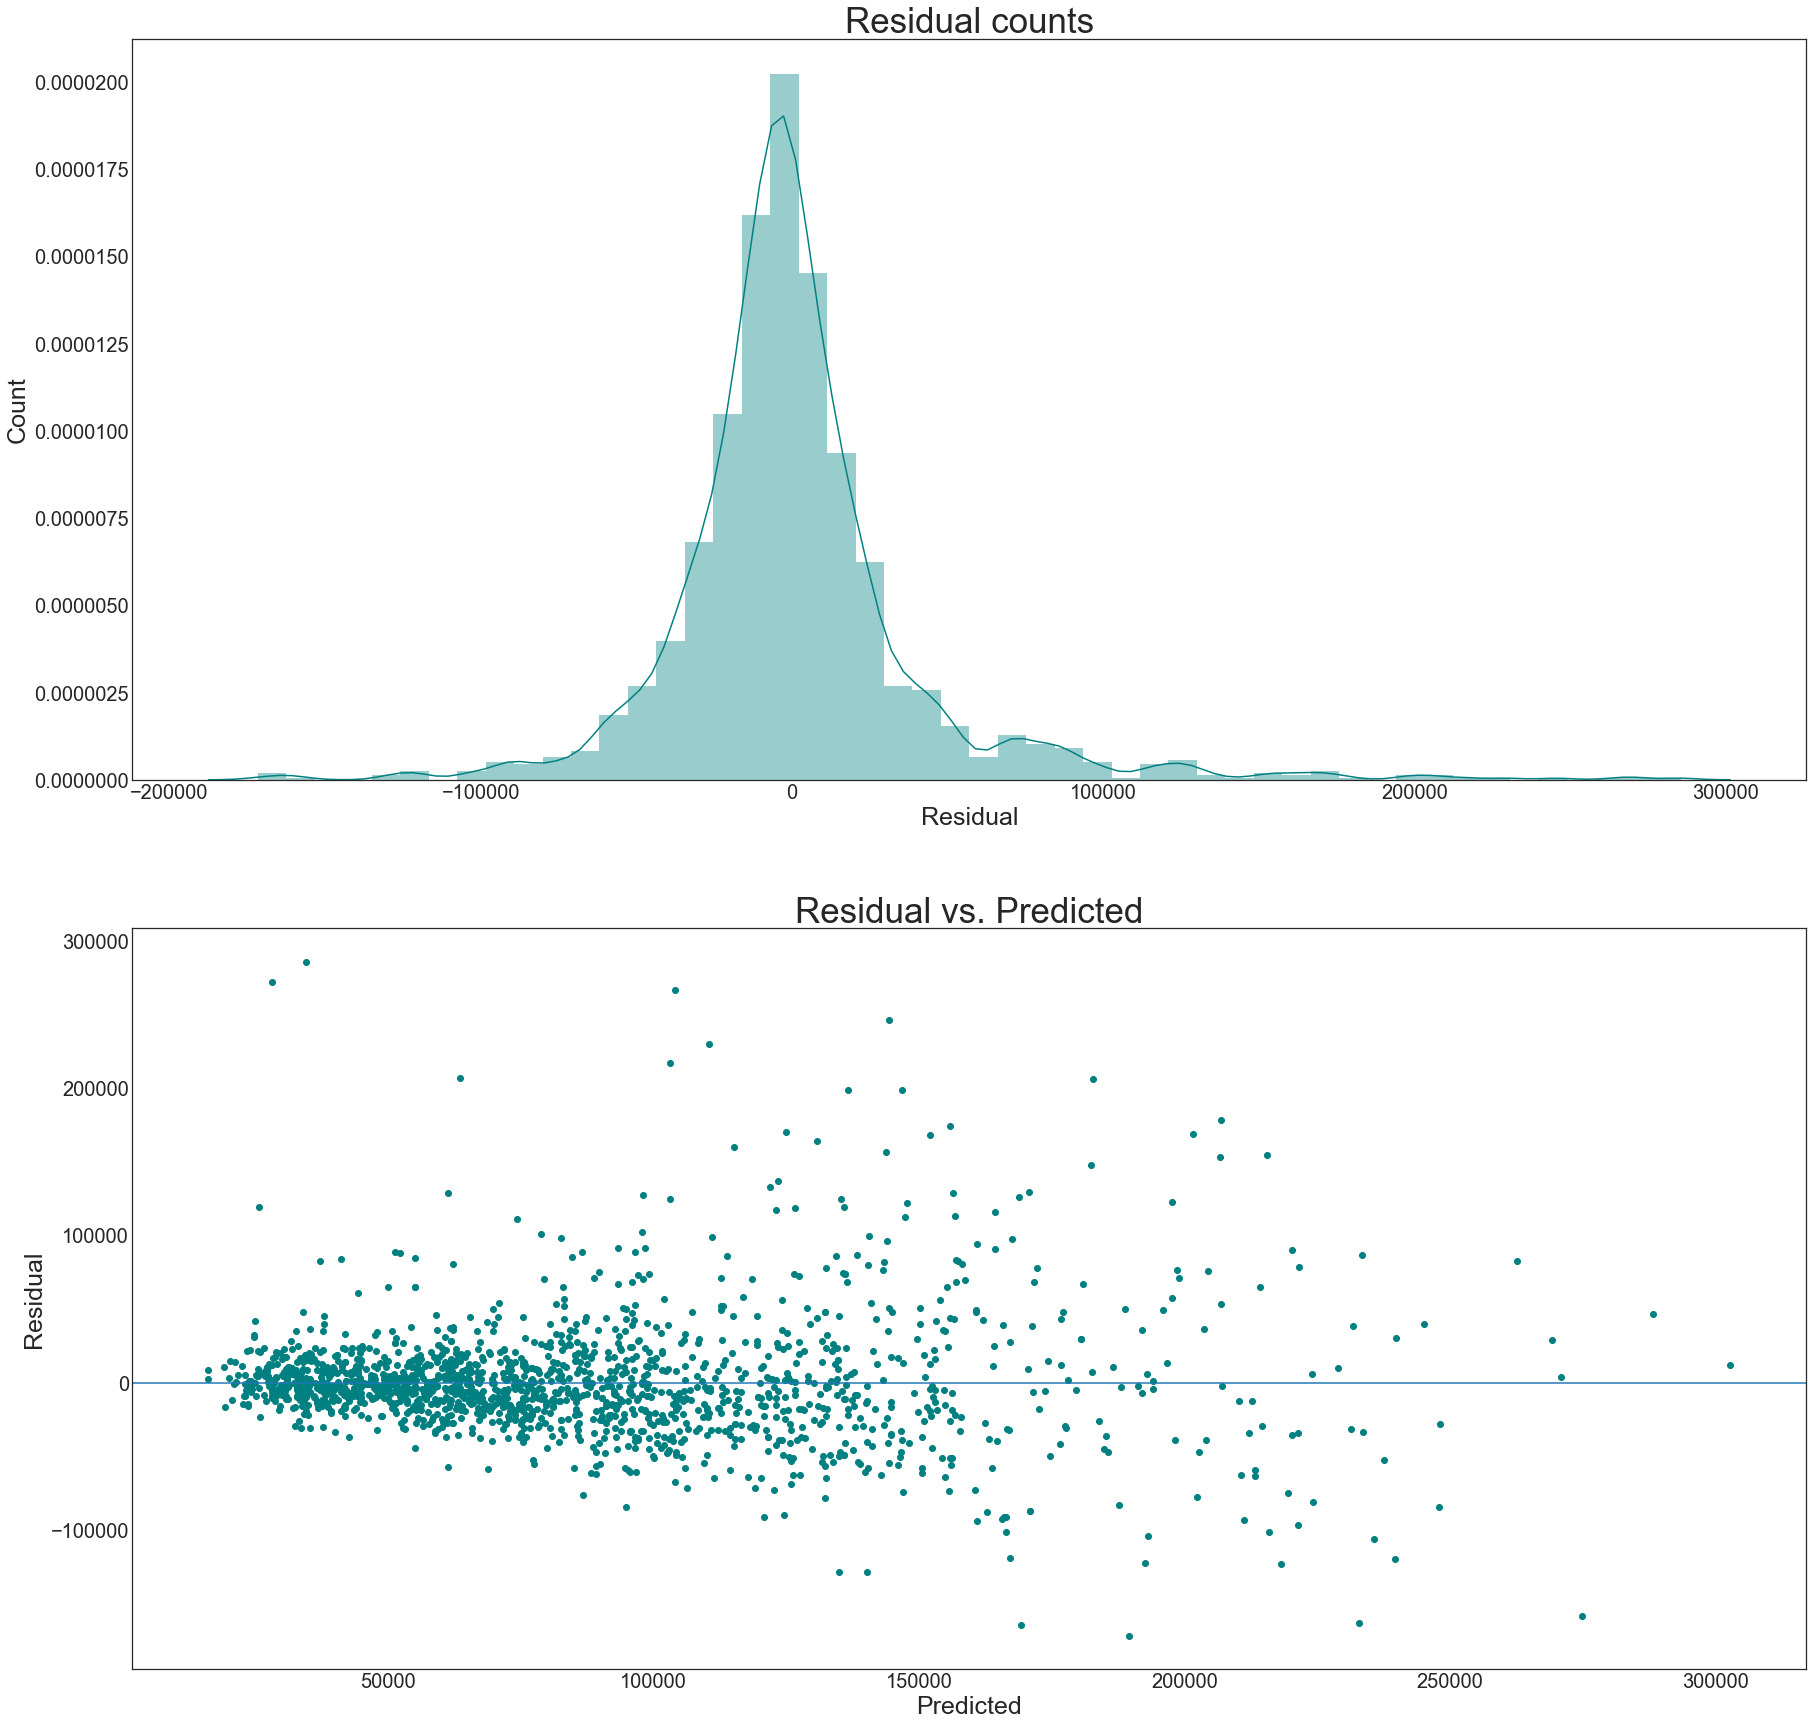

RMSE:
40558.527794536196


In [23]:
from sklearn import neighbors
# the value of n_neighbors will be changed when we plot the histogram showing the lowest RMSE value
knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, Y_train)

predicted = knn.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

# Linear Regression

/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


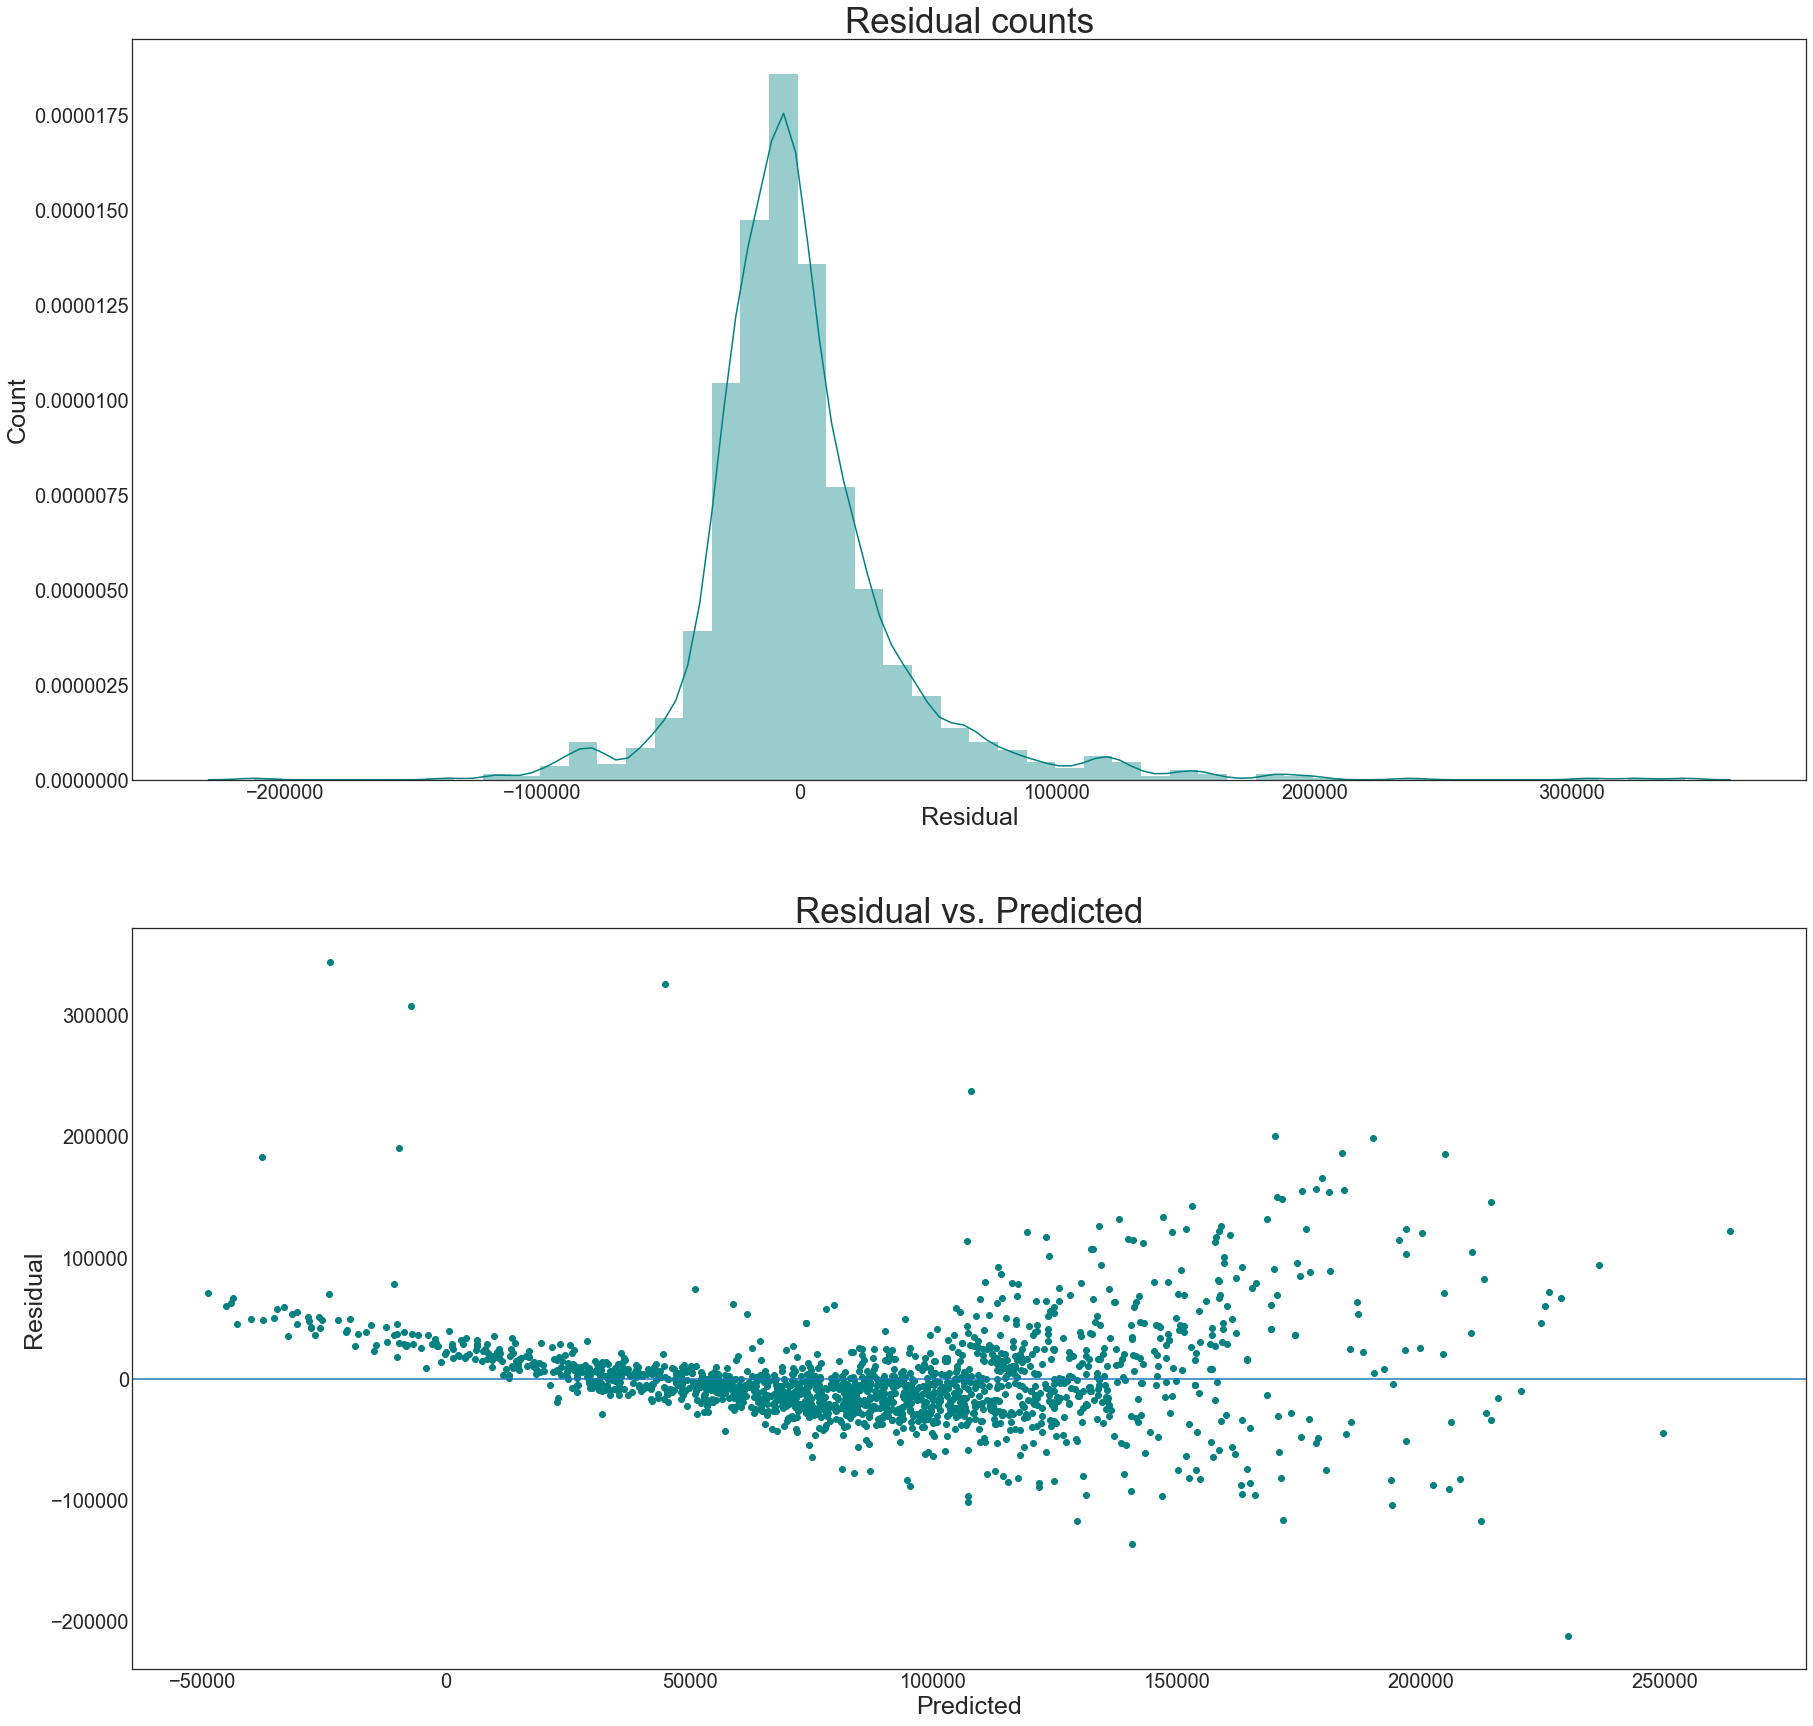

RMSE:
40006.8848721


In [27]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

predicted = regr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [30]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.58


# Decision Tree

/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


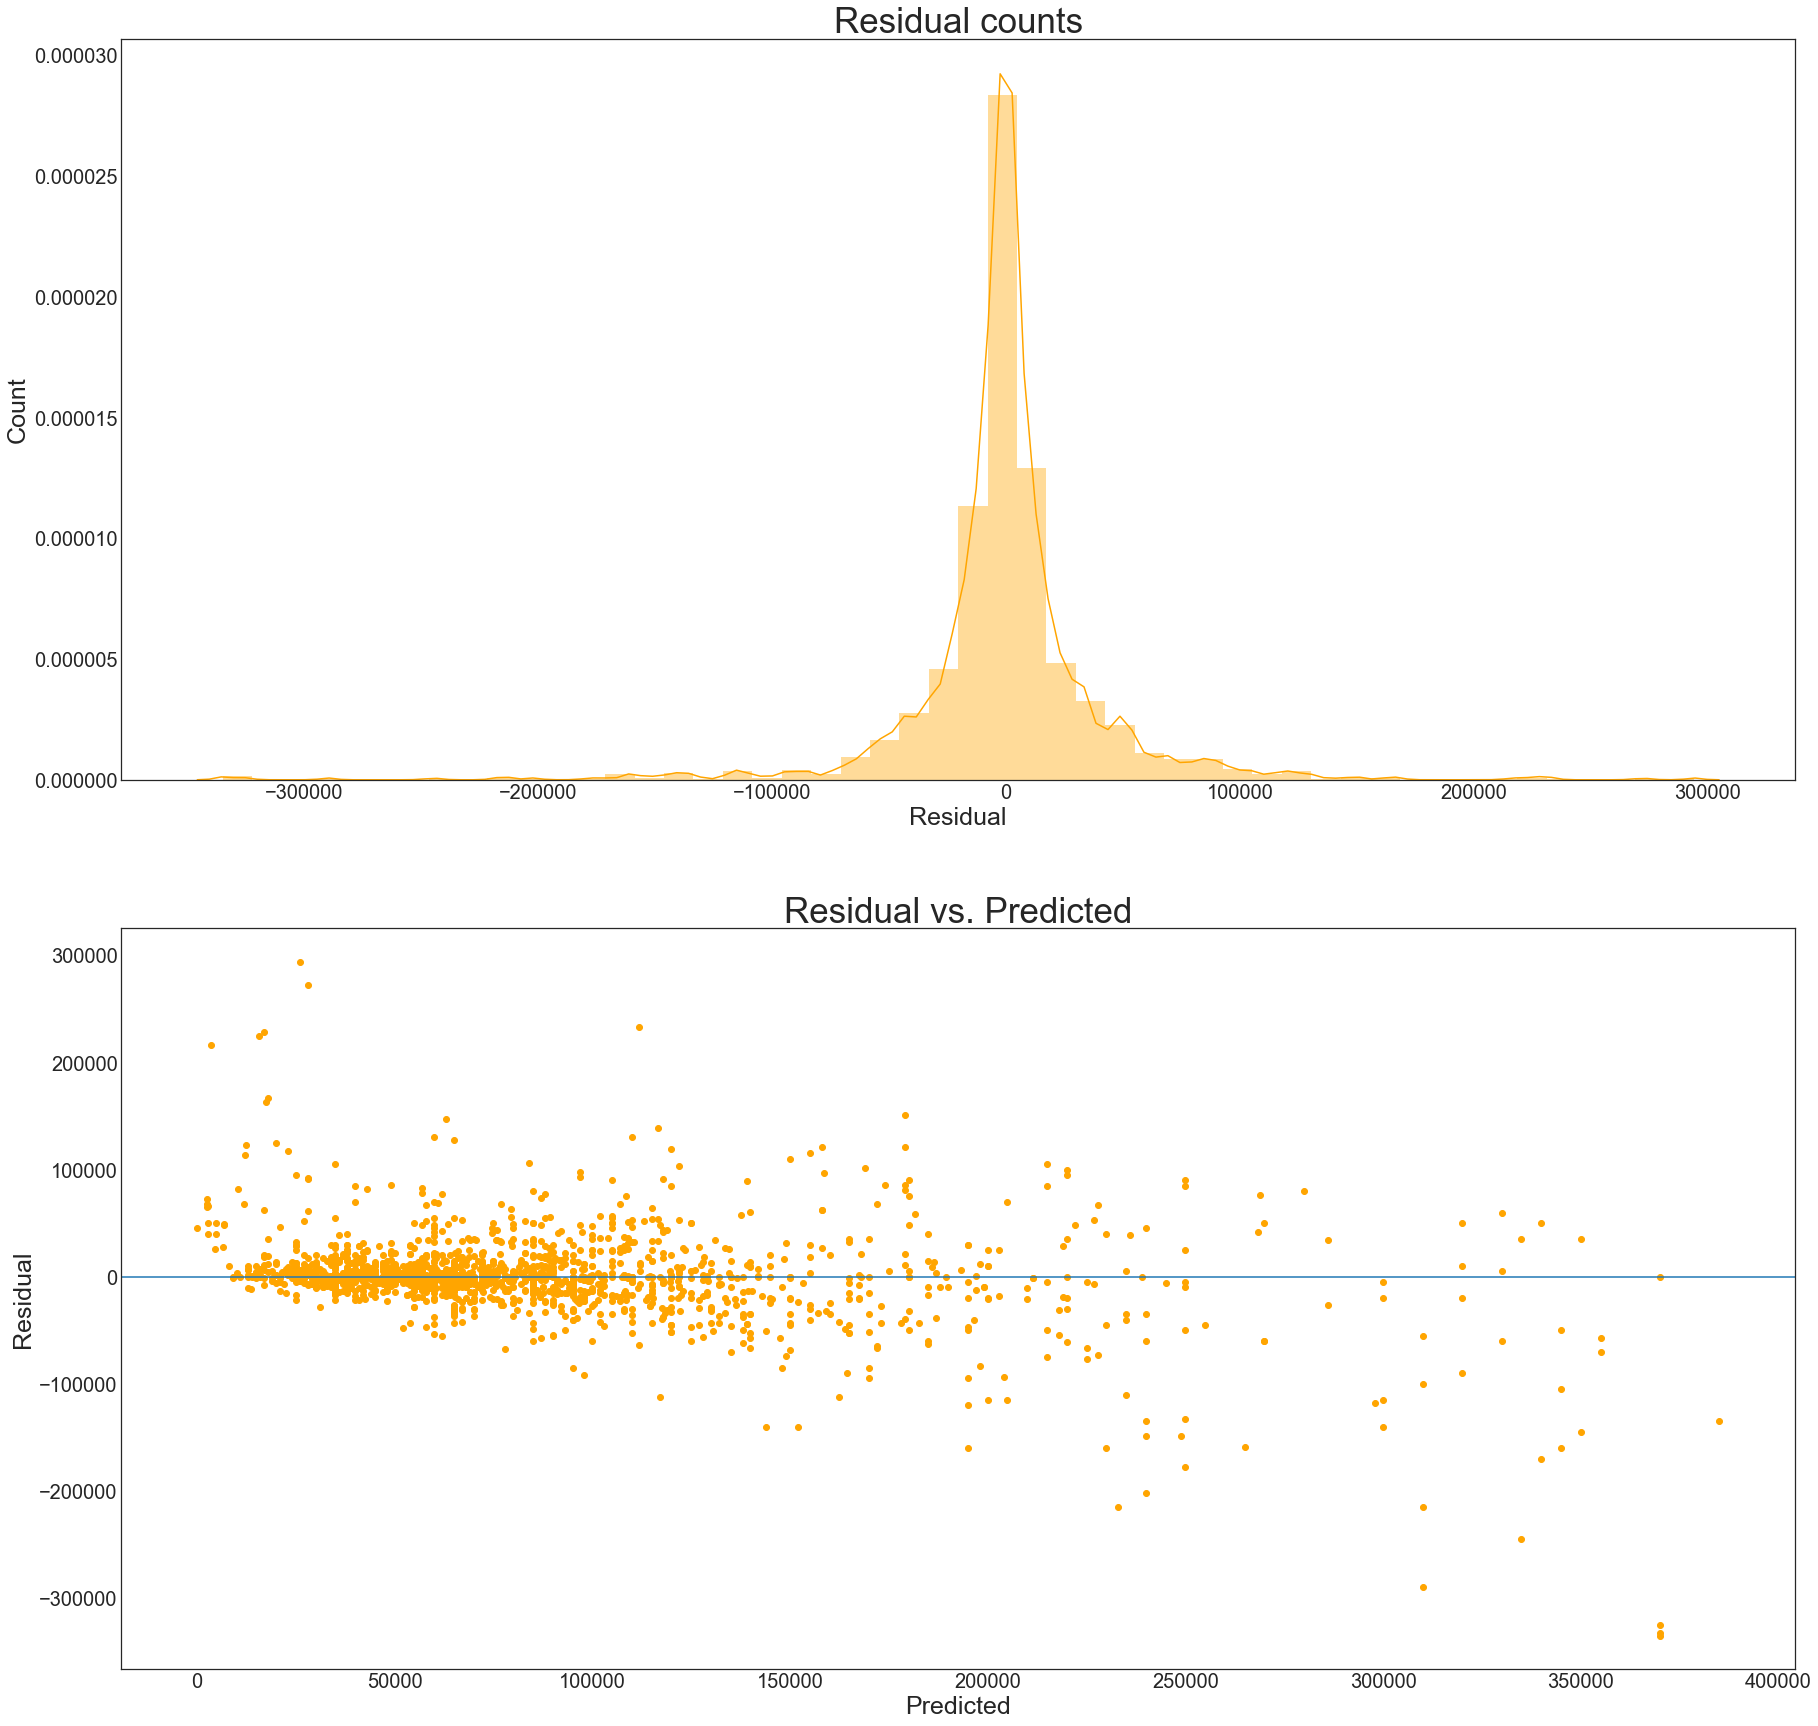

RMSE:
41518.6392275


In [31]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, Y_train)
predicted = dtr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [32]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.54


# Gradient Boosting 

/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


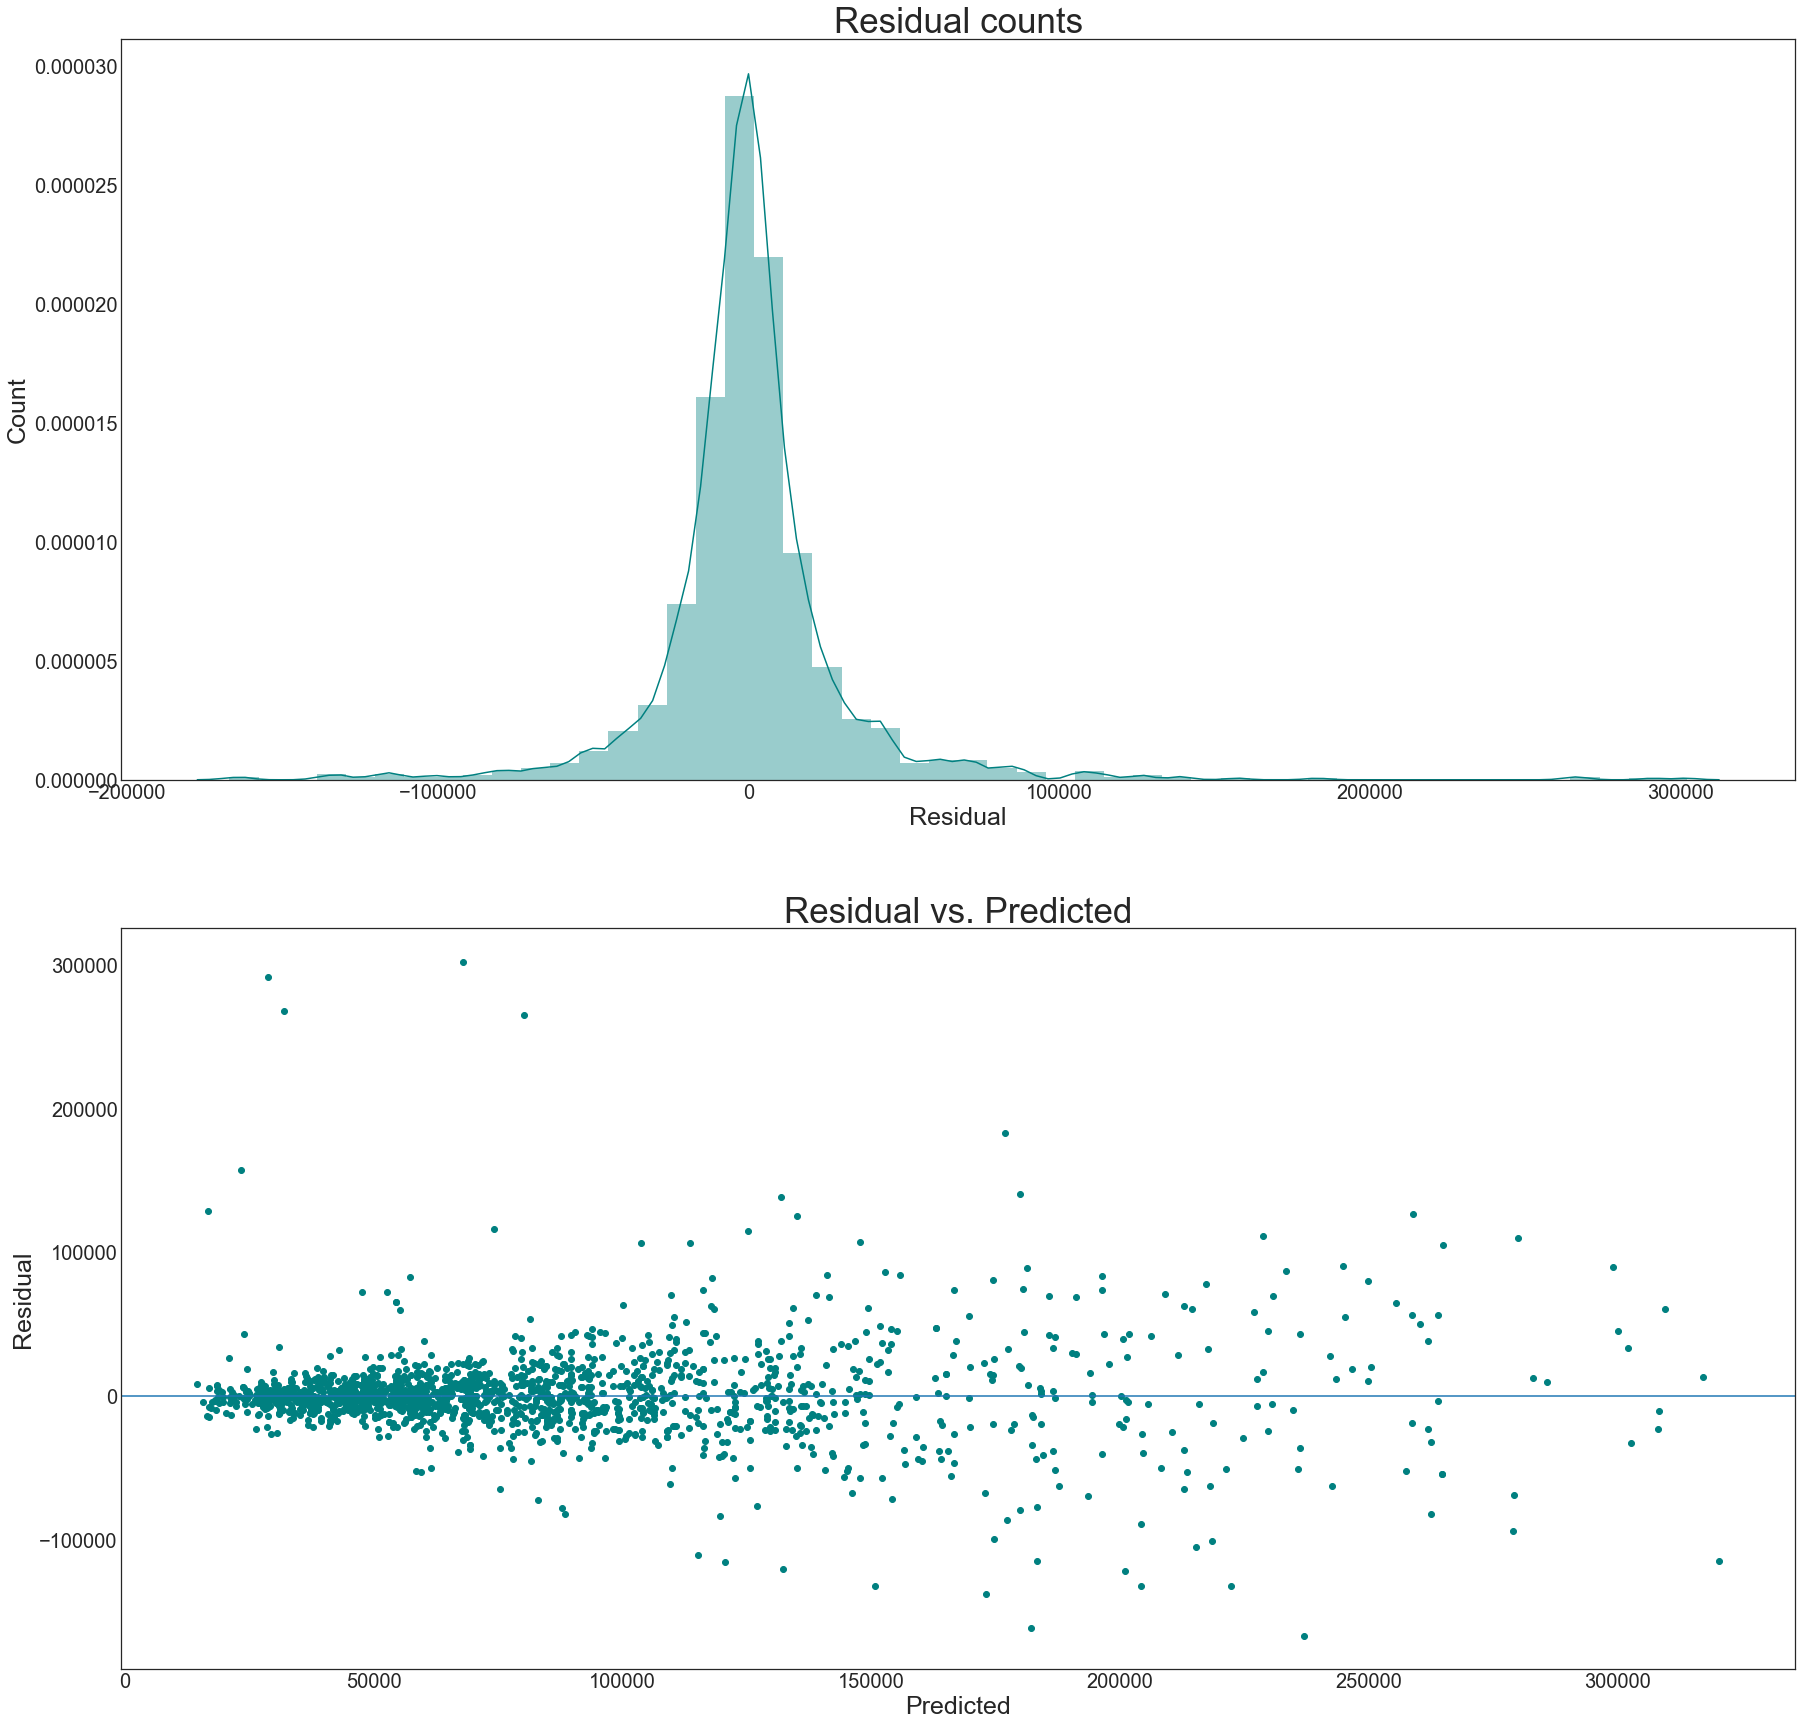


Cross Validation Scores:
[ 0.6776573   0.77711035  0.76739781  0.72569212  0.72355774  0.77850045
  0.73277589  0.67198881  0.68822646  0.74888526  0.73723794  0.74551219]

Mean Score:
0.731211860823

RMSE:
30999.2595873


In [33]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(loss ='ls', max_depth=6)
gbr.fit (X_train, Y_train)
predicted = gbr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

rmse = np.sqrt(mean_squared_error(Y_test, predicted))
scores = cross_val_score(gbr, X, Y, cv=12)

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

# Conclusion

After fitting all the techniques to the data the Gradient boostin gmodel achieves the best performance with an 
R^2 of 0.8 and 
an RMSE of 30999. 
So this is chosen to be the best model

predict ing the unseen observation


In [28]:
a=input_to_one_hot(user_input)

In [29]:
a.shape

(63,)

In [30]:
price_pred = gbr.predict([a])

In [67]:
price_pred[0]

90830.92717348192

In [31]:
##implementing flask and storing the model.

from sklearn.externals import joblib

joblib.dump(gbr, 'model.pkl')





['model.pkl']

In [32]:
gbr = joblib.load('model.pkl')

In [33]:
print("the best price for this Dacia is",gbr.predict([a])[0])


the best price for this Dacia is 90830.92717348192
